In [1]:
# check for requirements.txt

import os
import sys
import argparse

import torch
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
# from torch.utils.tensorboard import SummaryWriter #pytorch 1.12 버전에서 아직 지원 안됨. 1.3부터 지원.
from torchvision.datasets import FashionMNIST
from torchvision import transforms # callable
from tqdm import tqdm
from datetime import datetime

In [2]:
# check if GPu is available
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda


In [3]:
# Preprocessing & Dataset definition
data_root = os.path.join(os.getcwd(),"data")
# Composes several transforms together.
transform = transforms.Compose( 
    [
    transforms.ToTensor(), # PIL Image or ndarray-> FloatTensor with (c,h,w), Intensity to [0,1]
    transforms.Normalize([0.5],[0.5]) # normalize each channel of the input
    # mean (sequence) – Sequence of means for each channel.
    # std (sequence) – Sequence of standard deviations for each channel.
    ]
)
fashion_mnist_dataset = FashionMNIST(data_root, download=True, train=True, transform = transform)

In [4]:
data = random_split(fashion_mnist_dataset, [int(len(fashion_mnist_dataset)*0.9),int(len(fashion_mnist_dataset)*0.1)])
train_dataset = data[0]
val_dataset = data[1]

train_batchszie = 100
val_batchszie = 10

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batchszie, shuffle =True, num_workers=1
)
# Iterable object composed of iterable data

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=val_batchszie, shuffle =True, num_workers=1
)


In [5]:
def softmax(x,axis=0):
    max = np.max(x, axis=axis,keepdims=True)
    e_x = np.exp(x-max) #?
    sum = np.sum(e_x, axis=axis,keepdims=True)
    f_x = e_x/sum
    return f_x

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, h1_dim: int, h2_dim: int, h3_dim: int, output_dim: int):
        super().__init__()
        self.linear1 = nn.Linear(input_dim,h1_dim)
        self.linear2 = nn.Linear(h1_dim,h2_dim)
        self.linear3 = nn.Linear(h2_dim,h3_dim)
        self.linear4 = nn.Linear(h3_dim,h2_dim)
        self.linear5 = nn.Linear(h2_dim,output_dim)
        self.relu = F.relu
        self.softmax = F.softmax
        
    def forward(self,input):
        x = torch.flatten(input,start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.relu(self.linear4(x))
        output = self.softmax(self.linear5(x),dim=1)
        return output 
    
class MLPWithDropout(MLP):
    def __init__(self, input_dim: int, h1_dim: int, h2_dim: int, h3_dim: int, output_dim: int
                ,dropout_prob: float):
        super().__init__(input_dim, h1_dim, h2_dim, h3_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.dropout3 = nn.Dropout(dropout_prob)
        
    def forward(self,input):
        x = torch.flatten(input,start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.dropout1(x)
        x = self.relu(self.linear2(x))
        x = self.dropout2(x)
        x = self.relu(self.linear3(x)) 
        x = self.dropout3(x)
        x = self.relu(self.linear4(x))
        x = self.dropout(x)
        output = self.softmax(self.linear5(x),dim=1)
        return output

In [11]:
# Warmup Scheduler
class WarmupLR(optim.lr_scheduler.LambdaLR):
    def __init__(self,
                 optimizer: optim.Optimizer,
                 warmup_end_steps: int, 
                 last_epoch: int = -1,
                ):
        def warmup_fn(step: int):
            if step < warmup_end_steps:
                return float(step) / float(max(warmup_end_steps, 1))
            return 1.0
        super().__init__(optimizer, warmup_fn, last_epoch)

In [12]:
# model = MLP(28*28, 128, 64, 32, 10).to(device)
model = MLPWithDropout(28*28, 128, 64, 32, 10, 0.3).to(device)
model_name = type(model).__name__

loss_function = nn.CrossEntropyLoss()

lr=1e-3
optimizer= torch.optim.Adam(model.parameters(),lr)
optimizer_name = type(optimizer).__name__

scheduler = WarmupLR(optimizer, 1500)
scheduler_name = type(scheduler).__name__ if scheduler is not None else "no"
max_epoch=50

log_dir = f".\\logs\\{model_name}-{optimizer_name}_optim_{lr}_lr_with_{scheduler_name}_scheduler"
log_interval = 100
os.makedirs(log_dir, exist_ok=True)

In [ ]:
train_step = 0
logs = {
    'tr_bce_loss':[],
    'valid_bce_loss':[]
}
for epoch in range(1,max_epoch+1):
    
    # valid step
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        model.eval()
        
        for val_batch_idx, (val_images,val_labels) in enumerate(tqdm(val_dataloader,position=0,leave=True,desc='validation')):
            
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs,1)
            val_loss += loss_function(val_outputs,val_labels).item() / val_outputs.shape[0] # per batch
            val_corrects += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0] # per batch
            
    # Validation logging
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_acc = val_corrects / len(val_dataloader)
    logs['valid_bce_loss'].append(val_epoch_loss)
    
    print(
        f"{epoch}: epoch, {train_step} step: val_loss : {val_epoch_loss}, val_acc: {val_epoch_acc}"
    )
    model.train()
    
    # train step
    for batch_idx, (images,labels) in enumerate(tqdm(train_dataloader,position=0,leave=True,desc='Train')):
        current_loss = 0.0
        current_corrects = 0
        
        images = images.to(device)
        labels = labels.to(device)     
        
        #Forward
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        loss = loss_function(outputs,labels)
        
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        current_loss += loss.item()
        current_corrects += torch.sum(preds==labels.data)
        # Train logging
        if train_step % log_interval == 0: # Performance log per batch
            train_loss = current_loss / log_interval # average loss
            train_acc = current_corrects / log_interval # average acc
            print(
                f"{train_step}: train_loss : {train_loss}, train_acc: {train_acc}"
            )
            logs['tr_bce_loss'].append(train_loss)
            current_loss = 0
            current_corrects = 0
            
        train_step+=1

In [14]:
torch.save(model, log_dir+"/mlp.ckpt")

In [15]:
loaded_model = torch.load(log_dir+"/mlp.ckpt")
loaded_model.eval()
print(loaded_model)

MLPWithDropout(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
)


In [16]:
test_batch_size=100
test_dataset = FashionMNIST(data_root, download=True, train=False,transform=transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=test_batch_size, shuffle=False,num_workers=1)

test_labels_list = []
test_preds_list = []
test_outputs_list= []
for i, (test_images,test_labels) in enumerate(tqdm(test_dataloader,position=0,leave=True,desc='Test')):
    
    test_images = test_images.to(device)
    test_labels = test_labels.to(device)
    
    test_outputs = loaded_model(test_images)
    test_outputs = test_outputs.to(device)
    
    _, test_preds = torch.max(test_outputs,1)
    
    final_outputs = test_outputs.detach().cpu().numpy()
    test_outputs_list.extend(final_outputs)
    test_labels_list.extend(test_labels.detach().cpu().numpy())
    test_preds_list.extend(test_preds.detach().cpu().numpy())
    
test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f'\n acc :{np.mean(test_preds_list==test_labels_list)*100}%')

Test: 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.34it/s]


 acc :65.4%


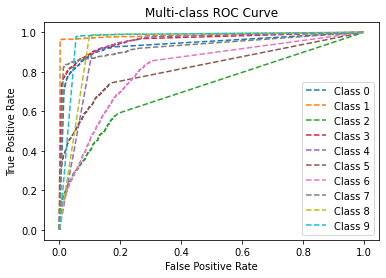

auc_score 0.8994967500000002


In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

false_positive_rate = {}
true_positive_rate = {}
threshold = {}
n_class = 10

for i in range(n_class):
    false_positive_rate[i],true_positive_rate[i],threshold[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:,i],pos_label=i)
for i in range(n_class):
    plt.plot(false_positive_rate[i],true_positive_rate[i],linestyle='--',label=f"Class {i}")
    
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

print("auc_score",roc_auc_score(test_labels_list,test_outputs_list,multi_class='ovo',average='macro'))

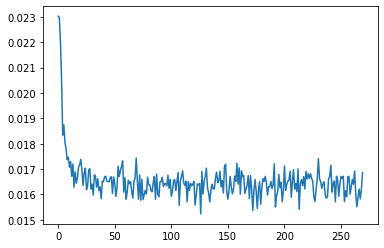

In [18]:
plt.plot(np.array(logs['tr_bce_loss']))

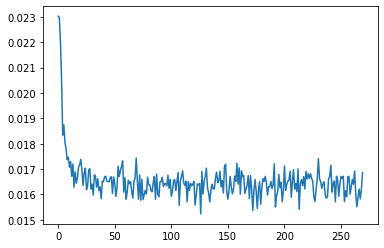

In [20]:
plt.plot(np.array(logs['tr_bce_loss']))